In [177]:
import numpy as np
import matplotlib.pyplot as plt
import tensortools as tt
import h5py

from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.manifold import SpectralEmbedding
import umap
import matplotlib.cm as cm
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import sys
from mpl_toolkits.mplot3d import Axes3D

# PCA & UMAP (reduce neurons dim)

## Means

In [178]:
data_folder = 'data_yue'
exps_dLGN_36_sample = [
    'CC182_240905_ThresholdedNaN3_Combined'
] 
exps_dLGN_36 = [
    'CC182_240905_ThresholdedNaN3_Combined', 
    'CC182_240906_ThresholdedNaN3_Combined', 
    'CC182_240911_ThresholdedNaN3_Combined', 
    'CC182_240912_ThresholdedNaN3_Combined', 
    'CC182_240913_ThresholdedNaN3_Combined', 
    'CC185_240916_ThresholdedNaN3_Combined', 
    'CC185_240917_ThresholdedNaN3_Combined', 
    'CC185_240919_ThresholdedNaN3_Combined' 
]
exps_dLGN_48 = [
    'CC185_241025_ThresholdedNaN3_Combined', 
    'CC185_241026_ThresholdedNaN3_Combined'
] 
exps_SC_48 = [
    'Mouse368_241107_ThresholdedNaN3_Combined', 
    'Mouse368_241108_ThresholdedNaN3_Combined', 
    'Mouse370_241109_ThresholdedNaN3_Combined'
]

experiments = exps_dLGN_36

# Average Files (dFFdotMeanValues):
# 4 (sessions) x 36 (stim conditions) cells
# within each cell, we find a matrix:
# 10 repeats x 73 neurons
# where each value is the mean dF/F for each trial (presentation)

# Traces files (dFFdotTraces):
# 4 (sessions) x 36 (stim conditions) cells
# within each cell, we find a tensor:
# # frames x # neurons x # repeats (including 2 sec before and after stimulus)
# i.e., 85 (frames-[2s off 1.5s on 2s off]) x *** (cell number) x 10 (repeats)

In [179]:
# N_REPS = 10  # Number of repetitions (repeats)
# N_NEURONS = 73  # Number of neurons
# N_SESSIONS = 4  # Number of sessions (runs)
# N_STIMS = 36  # Number of stimuli

# Get N_REPS/N_NEURONS/N_SESSIONS/N_STIMS from data

for exp in experiments:
    print(f"--- {exp} ---")
    prefix = '_'.join(exp.split('_')[:2]) + '_'
    mat_file_path = f'{data_folder}/{exp}/{prefix}Combined_dFFdotMeanValues.mat'
    with h5py.File(mat_file_path, 'r') as f:
        # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
        data = f['dFFdotMeanValues']
        # Check the shape of the dataset, should be (36, 4)
        N_STIMS, N_SESSIONS = data.shape
        print(f"Data outer-level shape: {data.shape}")  # Debugging statement: Expected shape (36, 4)
        N_NEURONS, N_REPS = f[data[0, 0]].shape
        print(f"Data inner-level shape: {f[data[0, 0]].shape}")

--- CC182_240905_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (71, 10)
--- CC182_240906_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (73, 10)
--- CC182_240911_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (63, 10)
--- CC182_240912_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (58, 10)
--- CC182_240913_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (74, 10)
--- CC185_240916_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (71, 10)
--- CC185_240917_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (95, 10)
--- CC185_240919_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (89, 10)


In [180]:
X_list = []
for exp in experiments:
    print(f"--- {exp} ---")
    prefix = '_'.join(exp.split('_')[:2]) + '_'
    mat_file_path = f'{data_folder}/{exp}/{prefix}Combined_dFFdotMeanValues.mat'
    with h5py.File(mat_file_path, 'r') as f:
        # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
        data = f['dFFdotMeanValues']

        N_STIMS, N_SESSIONS = data.shape
        N_NEURONS, N_REPS = f[data[0, 0]].shape

        X_ = np.zeros((N_SESSIONS*N_STIMS*N_REPS, N_NEURONS))

        for stim_i in range(N_STIMS):

            for session_i in range(N_SESSIONS):

                start = stim_i*N_SESSIONS*N_REPS + session_i*N_REPS
                end = stim_i*N_SESSIONS*N_REPS + (session_i+1)*N_REPS

                repetitions = f[data[stim_i, session_i]][:]
                repetitions = repetitions[:]
                repetitions = repetitions.T # Transpose to get the shape (10, 73)

                X_[start:end, :] = repetitions
    X_list.append(X_)

X = np.hstack(X_list)

print(f"X shape: {X.shape}")  # Debugging statement: Expected shape (1440, 73)
stimulus_labels = np.repeat(np.arange(N_STIMS), N_SESSIONS*N_REPS)
print(f"stimulus_labels shape: {stimulus_labels.shape}")  # Debugging statement: Expected shape (1440,)
display(stimulus_labels)
session_labels = np.repeat(np.arange(N_SESSIONS), N_STIMS*N_REPS)
print(f"session_labels shape: {session_labels.shape}")  # Debugging statement: Expected shape (1440,)
display(session_labels)
# 1440 = 4 * 36 *10

--- CC182_240905_ThresholdedNaN3_Combined ---
--- CC182_240906_ThresholdedNaN3_Combined ---
--- CC182_240911_ThresholdedNaN3_Combined ---
--- CC182_240912_ThresholdedNaN3_Combined ---
--- CC182_240913_ThresholdedNaN3_Combined ---
--- CC185_240916_ThresholdedNaN3_Combined ---
--- CC185_240917_ThresholdedNaN3_Combined ---
--- CC185_240919_ThresholdedNaN3_Combined ---
X shape: (1440, 594)
stimulus_labels shape: (1440,)


array([ 0,  0,  0, ..., 35, 35, 35])

session_labels shape: (1440,)


array([0, 0, 0, ..., 3, 3, 3])

In [181]:
label_names = [
    'neg_1flows_270', 'posneg_oppdir_270', 'pos_1flows_180', 'neg_3flows_180', 
    'posneg_samedir_270', 'neg_oppdir_180', 'gratings_90', 'pos_oppdir_0', 
    'pos_3flows_180', 'neg_1flows_0', 'pos_1flows_270', 'gratings_270', 
    'posneg_oppdir_0', 'neg_3flows_90', 'pos_oppdir_90', 'posneg_samedir_180', 
    'neg_oppdir_270', 'pos_3flows_270', 'neg_3flows_0', 'gratings_0', 
    'posneg_samedir_90', 'pos_3flows_0', 'neg_1flows_90', 'posneg_oppdir_180', 
    'neg_oppdir_0', 'pos_1flows_0', 'pos_oppdir_180', 'pos_oppdir_270', 
    'pos_1flows_90', 'posneg_oppdir_90', 'posneg_samedir_0', 'gratings_180', 
    'neg_1flows_180', 'neg_3flows_270', 'neg_oppdir_90', 'pos_3flows_90'
]


(1440, 20) <class 'numpy.ndarray'>


Text(0, 0.5, 'Explained Variance Ratio')

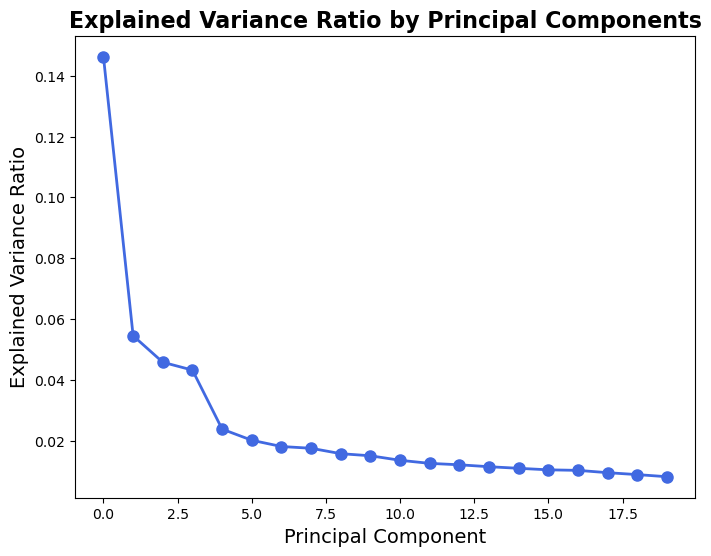

In [182]:
pca = PCA(20, random_state=42)
Y = pca.fit_transform(X)
print(Y.shape, type(Y))

plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Explained Variance Ratio by Principal Components', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)

In [183]:
# Initialize UMAP with the desired number of components
reducer = umap.UMAP(n_components=3, random_state=42)

Y_umap = reducer.fit_transform(X)
print("Shape of Y_umap:", Y_umap.shape)

c:\Users\hc879\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Shape of Y_umap: (1440, 3)


### All-label figs

C:\Users\hc879\AppData\Local\Temp\ipykernel_10640\2179239685.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



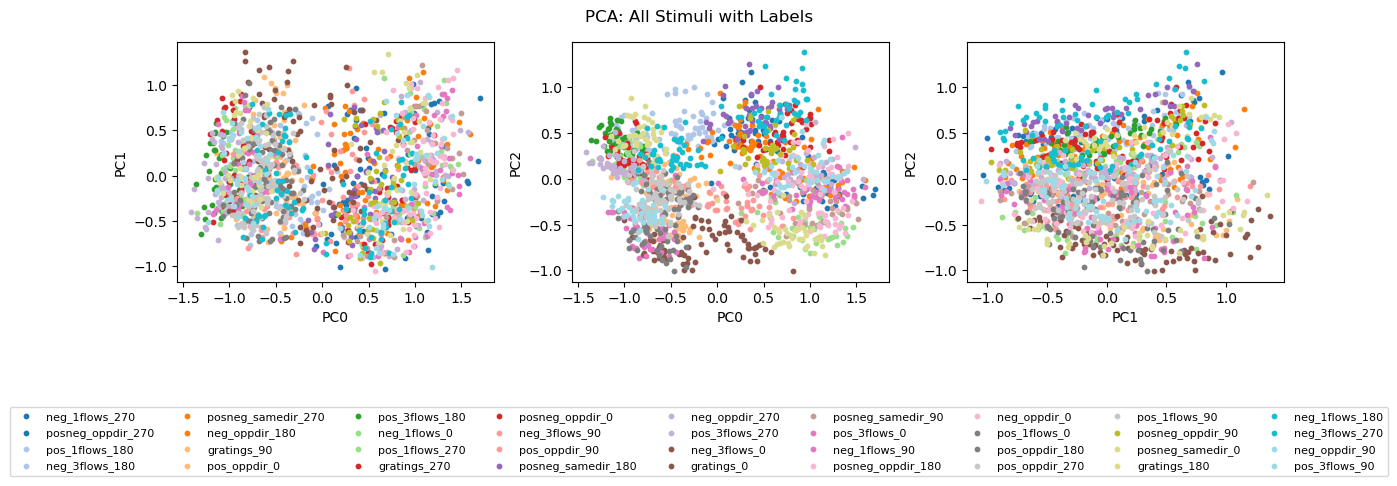

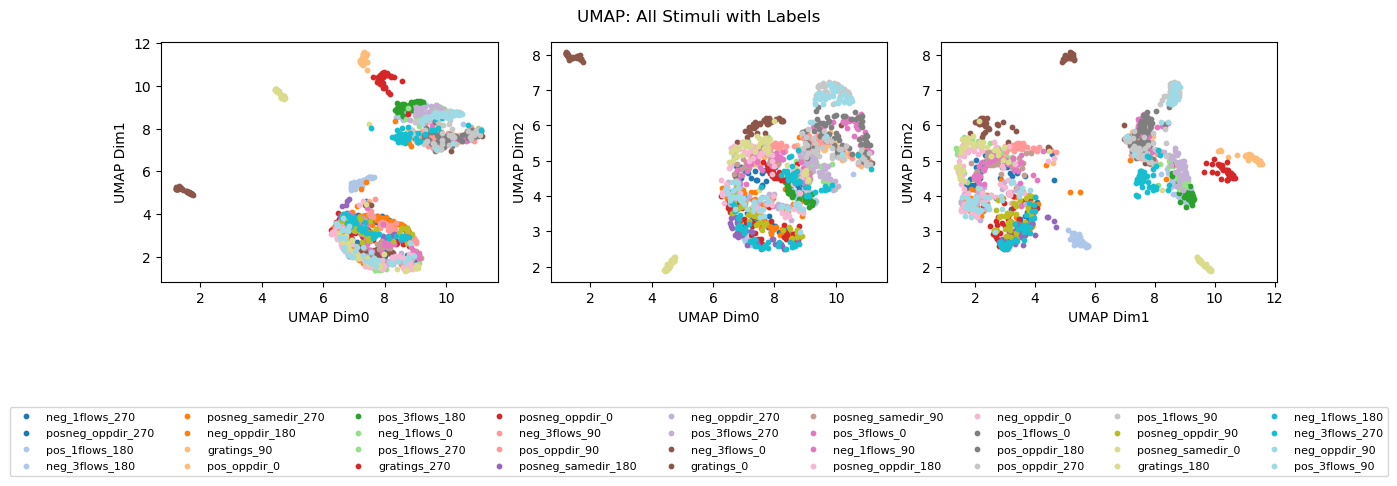

In [184]:
PCs = [(0, 1), (0, 2), (1, 2)]  # Define the PC pairs to plot
num_stimuli = len(label_names)  # This is 36
colors = cm.get_cmap('tab20', num_stimuli)  # Use a colormap with 36 distinct colors

# PCA Plot
f, axes = plt.subplots(1, len(PCs), figsize=(4 * len(PCs), 4))

for ax, pcs in zip(axes, PCs):
    for i in range(num_stimuli):
        # Create mask for each stimulus
        stimulus_mask = (stimulus_labels == i)
        # Plot points for each stimulus, assigning a unique color and label
        ax.scatter(*Y[stimulus_mask][:, pcs].T, c=[colors(i)], label=label_names[i], s=10)
    
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')

# Create a single legend below the plots
handles, labels = ax.get_legend_handles_labels()

f.suptitle('PCA: All Stimuli with Labels')
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=9, fontsize=8)  # Legend in 4x9 grid
f.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.3)  # Adjust space for the legend
plt.show()

# UMAP Plot
f, axes = plt.subplots(1, len(PCs), figsize=(4 * len(PCs), 4))

for ax, pcs in zip(axes, PCs):
    for i in range(num_stimuli):
        # Create mask for each stimulus
        stimulus_mask = (stimulus_labels == i)
        # Plot points for each stimulus, assigning a unique color and label
        ax.scatter(*Y_umap[stimulus_mask][:, pcs].T, c=[colors(i)], label=label_names[i], s=10)
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')

# Create a single legend below the plots
handles, labels = ax.get_legend_handles_labels()

f.suptitle('UMAP: All Stimuli with Labels')
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=9, fontsize=8)  # Legend in 4x9 grid
f.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.3)  # Adjust space for the legend
plt.show()

In [185]:
# Create a DataFrame to hold the PCA and UMAP data along with labels
df_pca = pd.DataFrame(Y[:, :3], columns=[f'PC{i}' for i in range(3)])
df_pca['stimulus'] = stimulus_labels
df_pca['stimulus_name'] = [label_names[i] for i in stimulus_labels]

df_umap = pd.DataFrame(Y_umap[:, :3], columns=[f'UMAP Dim{i}' for i in range(3)])
df_umap['stimulus'] = stimulus_labels
df_umap['stimulus_name'] = [label_names[i] for i in stimulus_labels]

# Plot PCA
fig_pca = px.scatter_matrix(
    df_pca,
    dimensions=['PC0', 'PC1', 'PC2'],
    color='stimulus_name',
    hover_name='stimulus_name',
    title='PCA: All Stimuli with Labels',
    labels={'stimulus_name': 'Stimulus'}
)

# Show stimulus name on hover
fig_pca.update_traces(marker=dict(size=6, opacity=0.8))

# Save the PCA plot as an HTML file
fig_pca.write_html('pca_of_means_interactive.html')
fig_pca.show()

# Plot UMAP
fig_umap = px.scatter_matrix(
    df_umap,
    dimensions=['UMAP Dim0', 'UMAP Dim1', 'UMAP Dim2'],
    color='stimulus_name',
    hover_name='stimulus_name',
    title='UMAP: All Stimuli with Labels',
    labels={'stimulus_name': 'Stimulus'}
)

# Show stimulus name on hover
fig_umap.update_traces(marker=dict(size=6, opacity=0.8))

# Save the UMAP plot as an HTML file
fig_umap.write_html('umap_of_means_interactive.html')
fig_umap.show()

In [186]:
# Create DataFrames for PCA and UMAP data with labels
df_pca = pd.DataFrame(Y[:, :3], columns=[f'PC{i}' for i in range(3)])
df_pca['stimulus'] = stimulus_labels
df_pca['stimulus_name'] = [label_names[i] for i in stimulus_labels]

df_umap = pd.DataFrame(Y_umap[:, :3], columns=[f'UMAP Dim{i}' for i in range(3)])
df_umap['stimulus'] = stimulus_labels
df_umap['stimulus_name'] = [label_names[i] for i in stimulus_labels]

# Define a colormap
colors = px.colors.qualitative.T10  # You can choose other color schemes from Plotly

# Function to map stimulus labels to colors
def get_color(label):
    return colors[label % len(colors)]

# =======================
# 3D PCA Plot
# =======================
fig_pca = go.Figure()

for i in range(len(label_names)):
    # Create mask for each stimulus
    stimulus_mask = (df_pca['stimulus'] == i)
    
    # Add a scatter trace for each stimulus
    fig_pca.add_trace(go.Scatter3d(
        x=df_pca[stimulus_mask]['PC0'],
        y=df_pca[stimulus_mask]['PC1'],
        z=df_pca[stimulus_mask]['PC2'],
        mode='markers',
        marker=dict(size=6, color=get_color(i), opacity=0.8),
        name=label_names[i],
        text=df_pca[stimulus_mask]['stimulus_name'],  # Hover text to show stimulus name
        hoverinfo='text'
    ))

# Update layout for PCA plot
fig_pca.update_layout(
    title='PCA: Interactive 3D Plot of All Stimuli',
    scene=dict(
        xaxis_title='PC0',
        yaxis_title='PC1',
        zaxis_title='PC2'
    ),
    legend=dict(
        x=0.1, y=0.9
    )
)

# Save the PCA plot as an HTML file
fig_pca.write_html('pca_of_means_3d_interactive.html')
fig_pca.show()

# =======================
# 3D UMAP Plot
# =======================
fig_umap = go.Figure()

for i in range(len(label_names)):
    # Create mask for each stimulus
    stimulus_mask = (df_umap['stimulus'] == i)
    
    # Add a scatter trace for each stimulus
    fig_umap.add_trace(go.Scatter3d(
        x=df_umap[stimulus_mask]['UMAP Dim0'],
        y=df_umap[stimulus_mask]['UMAP Dim1'],
        z=df_umap[stimulus_mask]['UMAP Dim2'],
        mode='markers',
        marker=dict(size=6, color=get_color(i), opacity=0.8),
        name=label_names[i],
        text=df_umap[stimulus_mask]['stimulus_name'],  # Hover text to show stimulus name
        hoverinfo='text'
    ))

# Update layout for UMAP plot
fig_umap.update_layout(
    title='UMAP: Interactive 3D Plot of All Stimuli',
    scene=dict(
        xaxis_title='UMAP Dim0',
        yaxis_title='UMAP Dim1',
        zaxis_title='UMAP Dim2'
    ),
    legend=dict(
        x=0.1, y=0.9
    )
)

# Save the UMAP plot as an HTML file
fig_umap.write_html('umap_of_means_3d_interactive.html')
fig_umap.show()

### Gratings vs all flows

In [187]:
gratings_ixs = [19, 6, 31, 11] #dir: 0, 90, 180, 270
neg_1flows_ixs = [9, 22, 32, 0]
pos_1flows_ixs = [25, 28, 2, 10]
neg_3flows_ixs = [18, 13, 3, 33]
pos_3flows_ixs = [21, 35, 8, 17]
pos_oppdir_ixs = [7, 14, 26, 27]
neg_oppdir_ixs = [24, 34, 5, 16]
posneg_samedir_ixs = [30, 20, 15, 4]
posneg_oppdir_ixs = [12, 29, 23, 1]

colors = {
    'A': (255/255, 99/255, 71/255),     # Red
    'B': (255/255, 165/255, 0/255),     # Orange
    'C': (135/255, 206/255, 250/255),   # Light Blue
    'D': (0/255, 51/255, 153/255),      # Deep Blue
    
    'I': (0/255, 128/255, 0/255),  # Dark Green
    'J': (128/255, 0/255, 128/255), # Purple

    'M': (0/255, 128/255, 128/255),  # Teal
    'N': (218/255, 165/255, 32/255),  # Goldenrod

    'Q': (211/255, 211/255, 211/255) # light gray
}

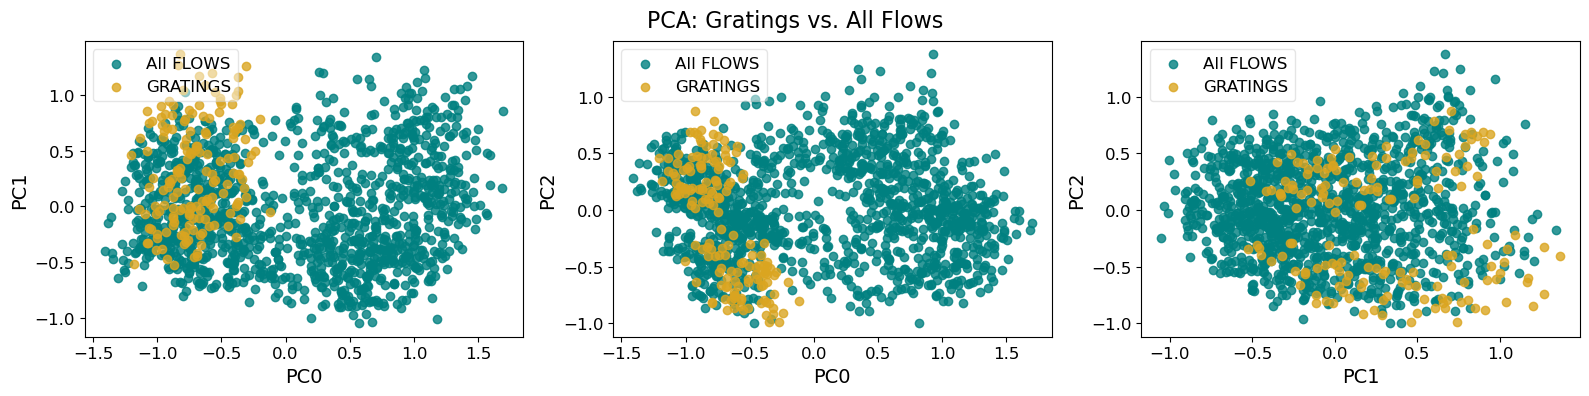

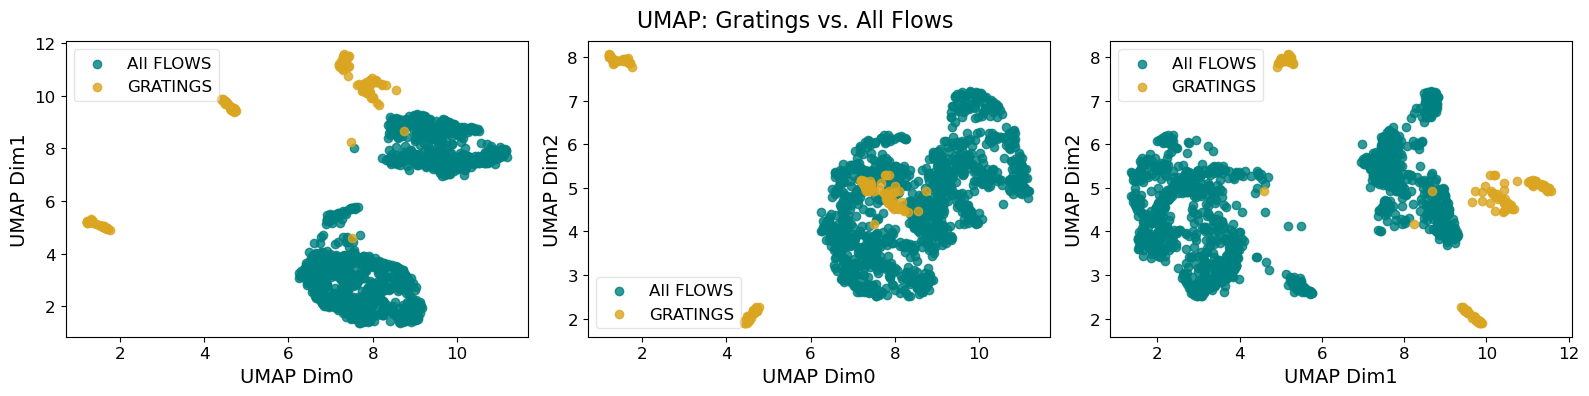

In [188]:
### GRATINGS vs. all FLOWS (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
gratings_vs_flows = np.zeros_like(stimulus_labels)

for i in gratings_ixs:
    gratings_vs_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    # Separate points into gratings and flows for custom legends
    gratings_mask = gratings_vs_flows == 1
    flows_mask = gratings_vs_flows == 0
    
    # Plot flows points
    ax.scatter(*Y[flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='All FLOWS')
    # Plot gratings points
    ax.scatter(*Y[gratings_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='GRATINGS')
    
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Gratings vs. All Flows', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap
labels_to_use = stimulus_labels
gratings_vs_flows = np.zeros_like(stimulus_labels)

for i in gratings_ixs:
    gratings_vs_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    # Separate points into gratings and flows for custom legends
    gratings_mask = gratings_vs_flows == 1
    flows_mask = gratings_vs_flows == 0
    
    # Plot flows points
    ax.scatter(*Y_umap[flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='All FLOWS')
    # Plot gratings points
    ax.scatter(*Y_umap[gratings_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='GRATINGS')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Gratings vs. All Flows', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Gratings directions

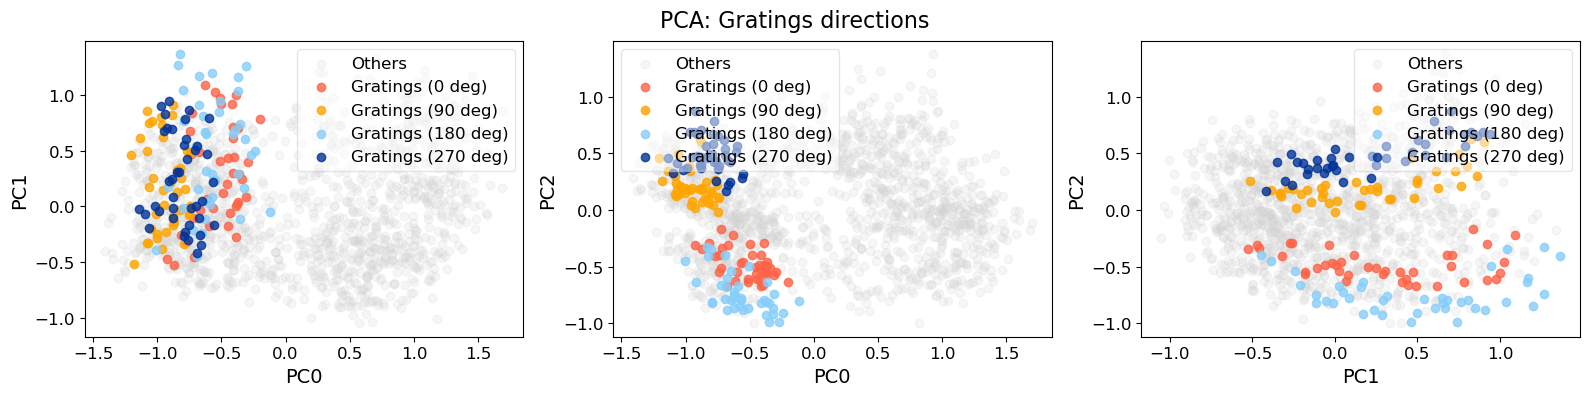

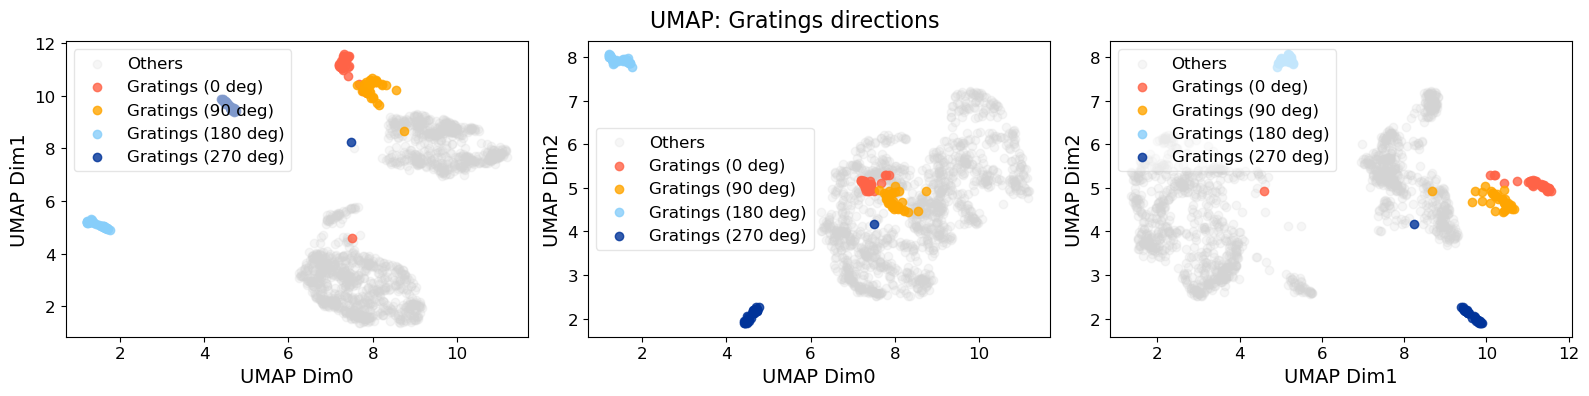

In [189]:
### Gratings directions (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
gratings_dirs = np.zeros_like(stimulus_labels)
gratings_dirs[(stimulus_labels == 6)] = 1
gratings_dirs[(stimulus_labels == 11)] = 2
gratings_dirs[(stimulus_labels == 19)] = 3
gratings_dirs[(stimulus_labels == 31)] = 4

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    d0_mask = gratings_dirs == 1
    d90_mask = gratings_dirs == 2
    d180_mask = gratings_dirs == 3
    d270_mask = gratings_dirs == 4
    others_mask = gratings_dirs == 0
    
    ax.scatter(*Y[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y[d0_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Gratings (0 deg)')
    ax.scatter(*Y[d90_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Gratings (90 deg)')
    ax.scatter(*Y[d180_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Gratings (180 deg)')
    ax.scatter(*Y[d270_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Gratings (270 deg)')

    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Gratings directions', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap
labels_to_use = stimulus_labels
gratings_dirs = np.zeros_like(stimulus_labels)
gratings_dirs[(stimulus_labels == 6)] = 1
gratings_dirs[(stimulus_labels == 11)] = 2
gratings_dirs[(stimulus_labels == 19)] = 3
gratings_dirs[(stimulus_labels == 31)] = 4

for i in gratings_ixs:
    gratings_vs_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    d0_mask = gratings_dirs == 1
    d90_mask = gratings_dirs == 2
    d180_mask = gratings_dirs == 3
    d270_mask = gratings_dirs == 4
    others_mask = gratings_dirs == 0
    
    ax.scatter(*Y_umap[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y_umap[d0_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Gratings (0 deg)')
    ax.scatter(*Y_umap[d90_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Gratings (90 deg)')
    ax.scatter(*Y_umap[d180_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Gratings (180 deg)')
    ax.scatter(*Y_umap[d270_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Gratings (270 deg)')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Gratings directions', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Pos vs neg flows (1-dot)

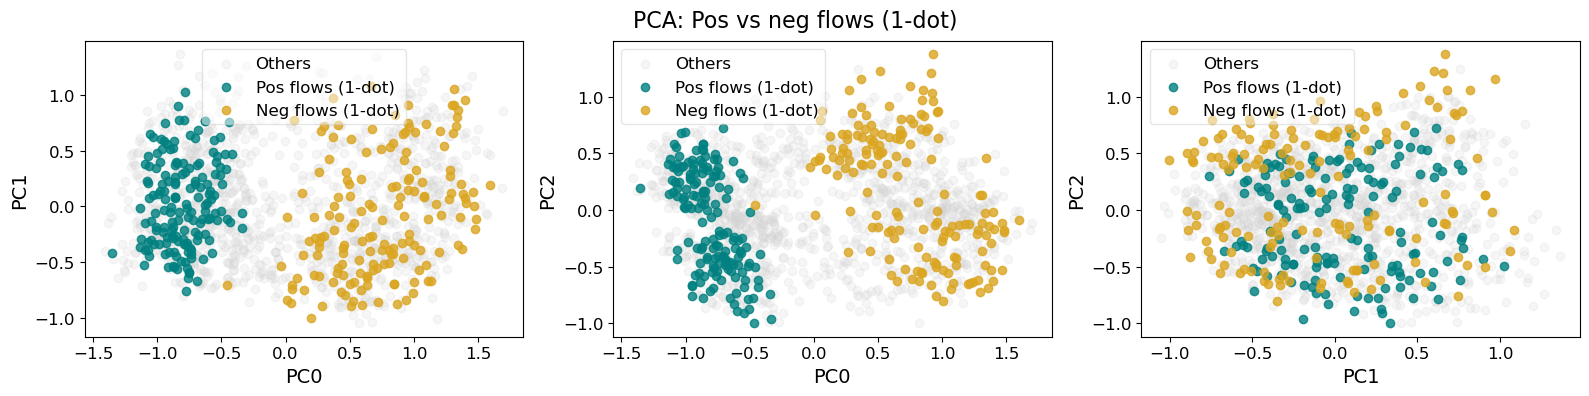

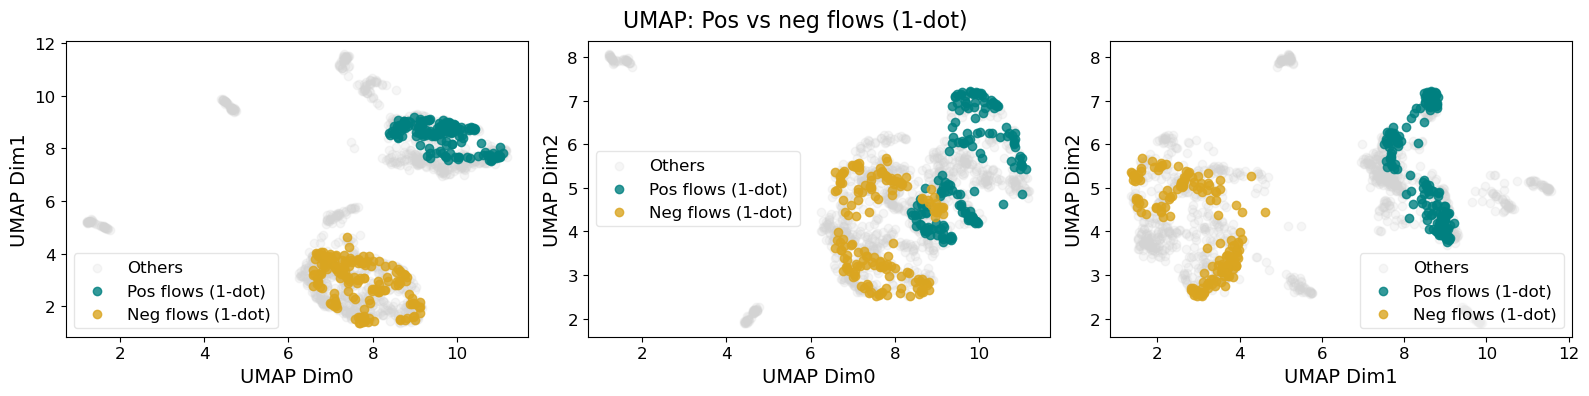

In [ ]:
### Pos vs neg flows (1-dot) (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in neg_1flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = -1
for i in pos_1flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    neg_flows_mask = pos_vs_neg_flows == -1
    pos_flows_mask = pos_vs_neg_flows == 1
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y[pos_flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='Pos flows (1-dot)')
    ax.scatter(*Y[neg_flows_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='Neg flows (1-dot)')

    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Pos vs neg flows (1-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap
f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    neg_flows_mask = pos_vs_neg_flows == -1
    pos_flows_mask = pos_vs_neg_flows == 1
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y_umap[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y_umap[pos_flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='Pos flows (1-dot)')
    ax.scatter(*Y_umap[neg_flows_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='Neg flows (1-dot)')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Pos vs neg flows (1-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Pos vs neg flows (3-dot)

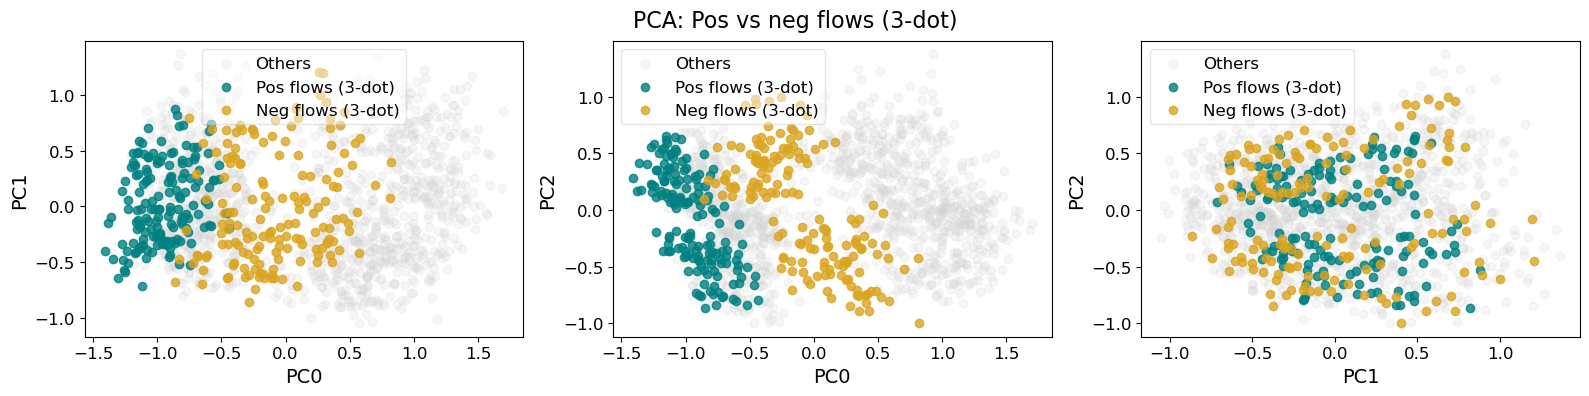

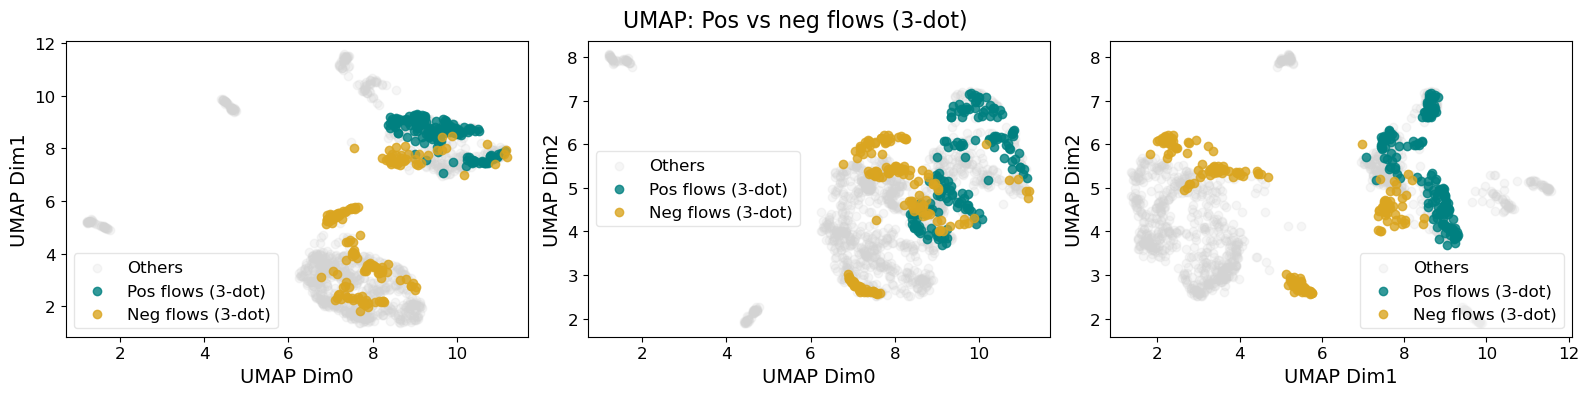

In [ ]:
### Pos vs neg flows (3-dot) (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in neg_3flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = -1
for i in pos_3flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    neg_flows_mask = pos_vs_neg_flows == -1
    pos_flows_mask = pos_vs_neg_flows == 1
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y[pos_flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='Pos flows (3-dot)')
    ax.scatter(*Y[neg_flows_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='Neg flows (3-dot)')

    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Pos vs neg flows (3-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    neg_flows_mask = pos_vs_neg_flows == -1
    pos_flows_mask = pos_vs_neg_flows == 1
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y_umap[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y_umap[pos_flows_mask][:, pcs].T, color=colors['M'], alpha=0.8, label='Pos flows (3-dot)')
    ax.scatter(*Y_umap[neg_flows_mask][:, pcs].T, color=colors['N'], alpha=0.8, label='Neg flows (3-dot)')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')

    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Pos vs neg flows (3-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Pos vs neg flows (1 & 3-dot)

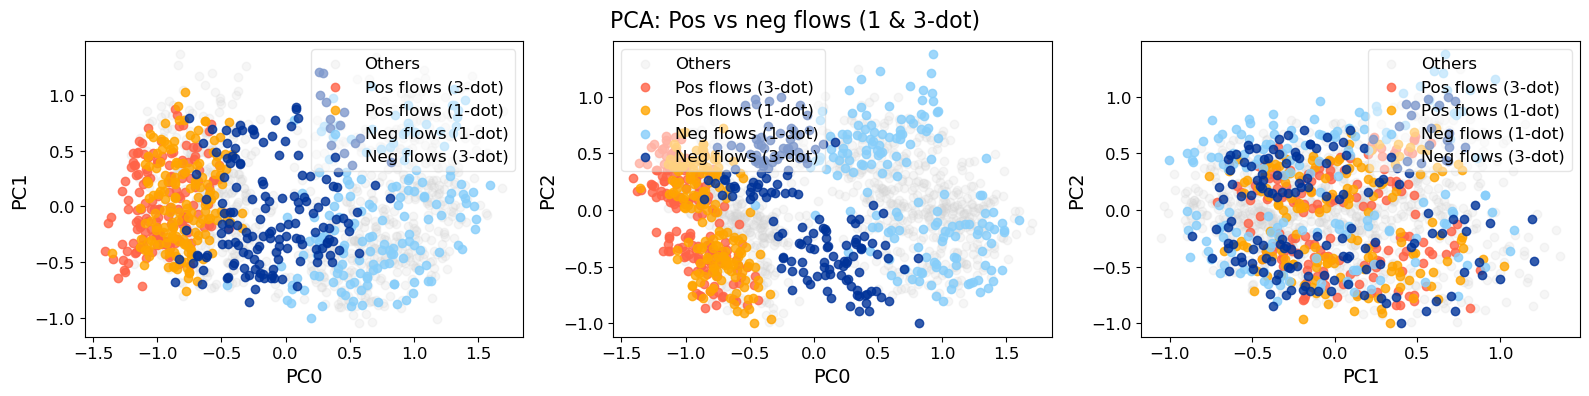

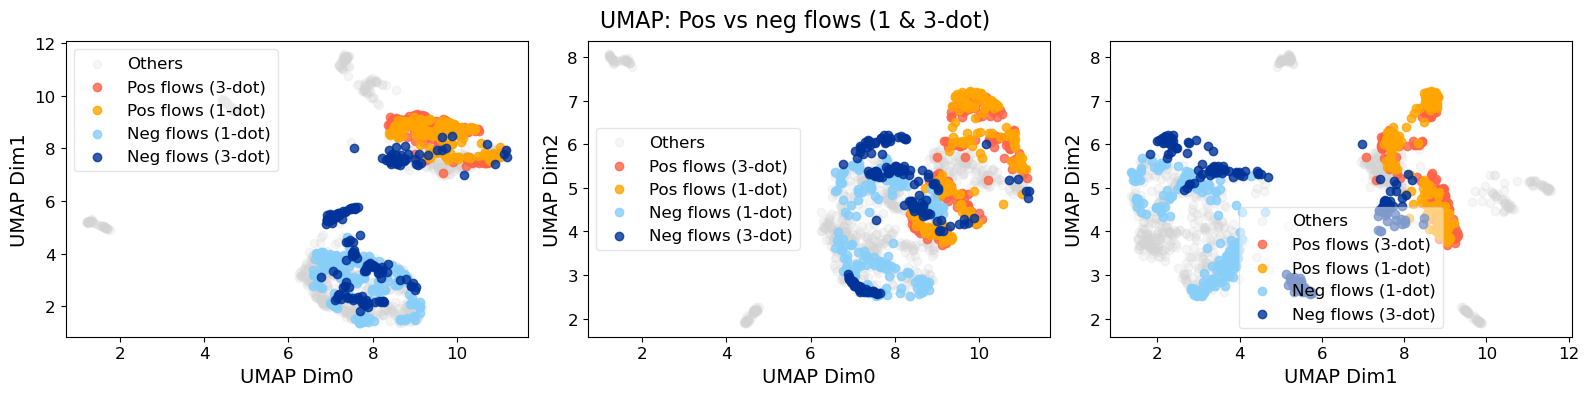

In [ ]:
### Pos vs neg flows (1 & 3-dot) (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in pos_3flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1
for i in pos_1flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 2
for i in neg_1flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 3
for i in neg_3flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 4


f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    p3_mask = pos_vs_neg_flows == 1
    p1_mask = pos_vs_neg_flows == 2
    n1_mask = pos_vs_neg_flows == 3
    n3_mask = pos_vs_neg_flows == 4
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y[p3_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Pos flows (3-dot)')
    ax.scatter(*Y[p1_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Pos flows (1-dot)')
    ax.scatter(*Y[n1_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Neg flows (1-dot)')
    ax.scatter(*Y[n3_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Neg flows (3-dot)')

    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Pos vs neg flows (1 & 3-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    p3_mask = pos_vs_neg_flows == 1
    p1_mask = pos_vs_neg_flows == 2
    n1_mask = pos_vs_neg_flows == 3
    n3_mask = pos_vs_neg_flows == 4
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y_umap[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y_umap[p3_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Pos flows (3-dot)')
    ax.scatter(*Y_umap[p1_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Pos flows (1-dot)')
    ax.scatter(*Y_umap[n1_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Neg flows (1-dot)')
    ax.scatter(*Y_umap[n3_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Neg flows (3-dot)')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Pos vs neg flows (1 & 3-dot)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Pos vs neg flows (same & opp)

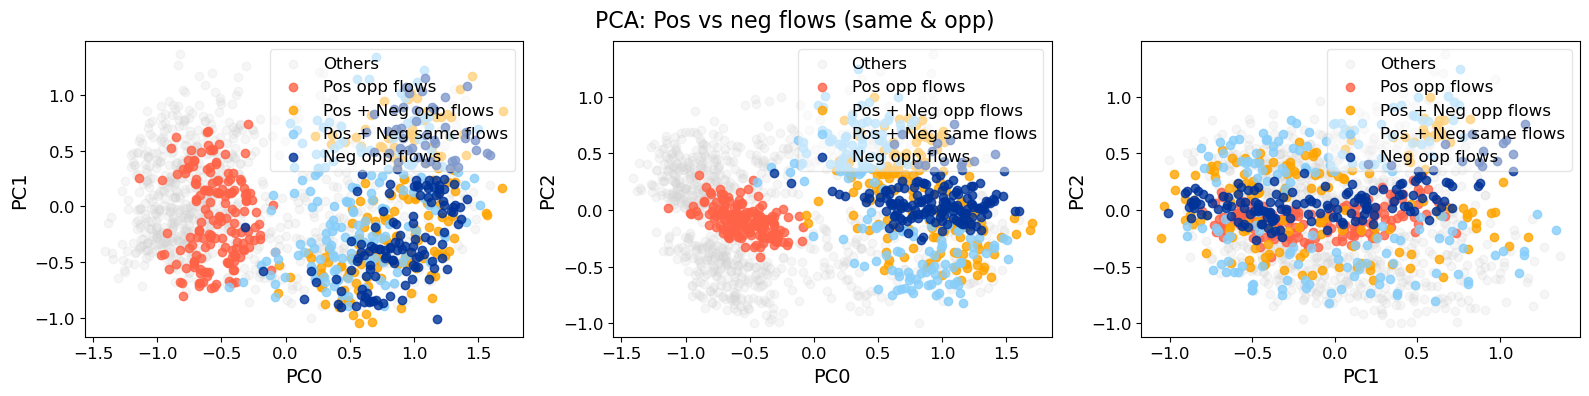

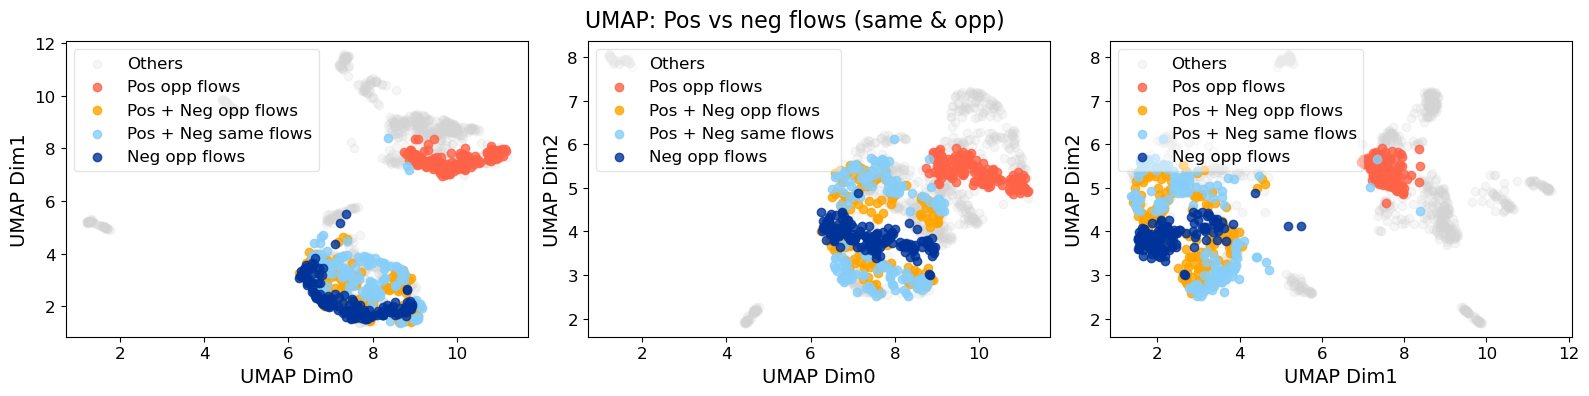

In [193]:
### Pos vs neg flows (same & opp) (PCA and UMAP)

PCs = [(0,1), (0,2), (1,2)]

# pca
labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in pos_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1
for i in posneg_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 2
for i in posneg_samedir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 3
for i in neg_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 4

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    p3_mask = pos_vs_neg_flows == 1
    p1_mask = pos_vs_neg_flows == 2
    n1_mask = pos_vs_neg_flows == 3
    n3_mask = pos_vs_neg_flows == 4
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y[p3_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Pos opp flows')
    ax.scatter(*Y[p1_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Pos + Neg opp flows')
    ax.scatter(*Y[n1_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Pos + Neg same flows')
    ax.scatter(*Y[n3_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Neg opp flows')

    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('PCA: Pos vs neg flows (same & opp)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# umap
labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in pos_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1
for i in posneg_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 2
for i in posneg_samedir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 3
for i in neg_oppdir_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 4

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    p3_mask = pos_vs_neg_flows == 1
    p1_mask = pos_vs_neg_flows == 2
    n1_mask = pos_vs_neg_flows == 3
    n3_mask = pos_vs_neg_flows == 4
    others_mask = pos_vs_neg_flows == 0
    
    ax.scatter(*Y_umap[others_mask][:, pcs].T, color=colors['Q'], alpha=0.2, label='Others')
    ax.scatter(*Y_umap[p3_mask][:, pcs].T, color=colors['A'], alpha=0.8, label='Pos opp flows')
    ax.scatter(*Y_umap[p1_mask][:, pcs].T, color=colors['B'], alpha=0.8, label='Pos + Neg opp flows')
    ax.scatter(*Y_umap[n1_mask][:, pcs].T, color=colors['C'], alpha=0.8, label='Pos + Neg same flows')
    ax.scatter(*Y_umap[n3_mask][:, pcs].T, color=colors['D'], alpha=0.8, label='Neg opp flows')
    
    ax.set(xlabel=f'UMAP Dim{pcs[0]}', ylabel=f'UMAP Dim{pcs[1]}')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, framealpha=0.5)

f.tight_layout()
plt.suptitle('UMAP: Pos vs neg flows (same & opp)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# PCA & UMAP (reduce stimuli dim)

## Means

In [194]:
# N_REPS = 10  # Number of repetitions (repeats)
# N_NEURONS = 73  # Number of neurons
# N_SESSIONS = 4  # Number of sessions (runs)
# N_STIMS = 36  # Number of stimuli

# Get N_REPS/N_NEURONS/N_SESSIONS/N_STIMS from data

for exp in experiments:
    print(f"--- {exp} ---")
    prefix = '_'.join(exp.split('_')[:2]) + '_'
    mat_file_path = f'{data_folder}/{exp}/{prefix}Combined_dFFdotMeanValues.mat'
    with h5py.File(mat_file_path, 'r') as f:
        # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
        data = f['dFFdotMeanValues']
        # Check the shape of the dataset, should be (36, 4)
        N_STIMS, N_SESSIONS = data.shape
        print(f"Data outer-level shape: {data.shape}")  # Debugging statement: Expected shape (36, 4)
        N_NEURONS, N_REPS = f[data[0, 0]].shape
        print(f"Data inner-level shape: {f[data[0, 0]].shape}")

--- CC182_240905_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (71, 10)
--- CC182_240906_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (73, 10)
--- CC182_240911_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (63, 10)
--- CC182_240912_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (58, 10)
--- CC182_240913_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (74, 10)
--- CC185_240916_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (71, 10)
--- CC185_240917_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (95, 10)
--- CC185_240919_ThresholdedNaN3_Combined ---
Data outer-level shape: (36, 4)
Data inner-level shape: (89, 10)


In [195]:
X_list = []
for exp in experiments:
    print(f"--- {exp} ---")
    prefix = '_'.join(exp.split('_')[:2]) + '_'
    mat_file_path = f'{data_folder}/{exp}/{prefix}Combined_dFFdotMeanValues.mat'
    with h5py.File(mat_file_path, 'r') as f:
        # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
        data = f['dFFdotMeanValues']

        N_STIMS, N_SESSIONS = data.shape
        N_NEURONS, N_REPS = f[data[0, 0]].shape

        X_ = np.zeros((N_SESSIONS*N_STIMS*N_REPS, N_NEURONS))

        for stim_i in range(N_STIMS):

            for session_i in range(N_SESSIONS):

                start = stim_i*N_SESSIONS*N_REPS + session_i*N_REPS
                end = stim_i*N_SESSIONS*N_REPS + (session_i+1)*N_REPS

                repetitions = f[data[stim_i, session_i]][:]
                repetitions = repetitions[:]
                repetitions = repetitions.T # Transpose to get the shape (10, 73)

                X_[start:end, :] = repetitions
    X_list.append(X_)

X = np.hstack(X_list)

print(f"X shape: {X.shape}")  # Debugging statement: Expected shape (1440, 73)
stimulus_labels = np.repeat(np.arange(N_STIMS), N_SESSIONS*N_REPS)
print(f"stimulus_labels shape: {stimulus_labels.shape}")  # Debugging statement: Expected shape (1440,)
display(stimulus_labels)
session_labels = np.repeat(np.arange(N_SESSIONS), N_STIMS*N_REPS)
print(f"session_labels shape: {session_labels.shape}")  # Debugging statement: Expected shape (1440,)
display(session_labels)
# 1440 = 4 * 36 *10

--- CC182_240905_ThresholdedNaN3_Combined ---
--- CC182_240906_ThresholdedNaN3_Combined ---
--- CC182_240911_ThresholdedNaN3_Combined ---
--- CC182_240912_ThresholdedNaN3_Combined ---
--- CC182_240913_ThresholdedNaN3_Combined ---
--- CC185_240916_ThresholdedNaN3_Combined ---
--- CC185_240917_ThresholdedNaN3_Combined ---
--- CC185_240919_ThresholdedNaN3_Combined ---
X shape: (1440, 594)
stimulus_labels shape: (1440,)


array([ 0,  0,  0, ..., 35, 35, 35])

session_labels shape: (1440,)


array([0, 0, 0, ..., 3, 3, 3])

In [196]:
X = X.T # change to neuron dim for reduction

(594, 20) <class 'numpy.ndarray'>


Text(0, 0.5, 'Explained Variance Ratio')

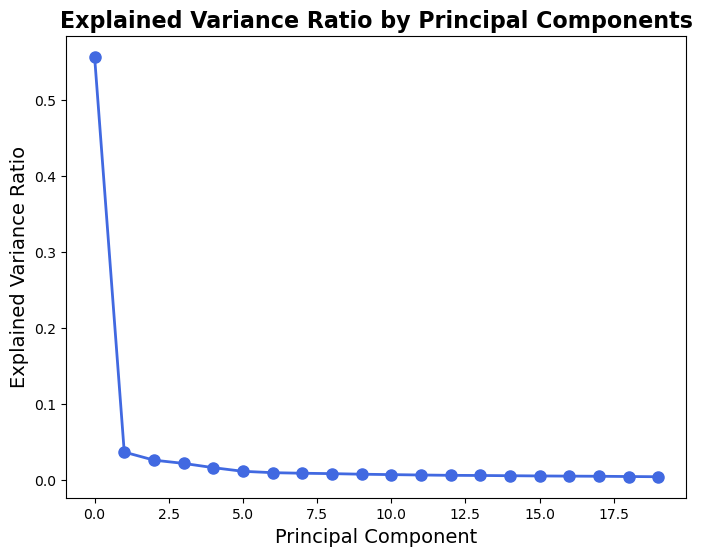

In [197]:
pca = PCA(20, random_state=42)
Y = pca.fit_transform(X)
print(Y.shape, type(Y))

plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Explained Variance Ratio by Principal Components', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)

In [198]:
# Initialize UMAP with the desired number of components
reducer = umap.UMAP(n_components=3, random_state=42)

Y_umap = reducer.fit_transform(X)
print("Shape of Y_umap:", Y_umap.shape)

c:\Users\hc879\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Shape of Y_umap: (594, 3)


In [199]:
Y_pca = Y[:,:3]  
Y_umap = Y_umap 

# Number of neurons
num_neurons = Y_pca.shape[0]
neuron_ids = [f"Neuron {i+1}" for i in range(num_neurons)]  # Creating labels for neurons

# =======================
# 3D PCA Plot
# =======================
fig_pca = go.Figure()

fig_pca.add_trace(go.Scatter3d(
    x=Y_pca[:, 0], 
    y=Y_pca[:, 1], 
    z=Y_pca[:, 2],
    mode='markers',
    marker=dict(size=6, color=np.arange(num_neurons), colorscale='Viridis', opacity=0.8),
    text=neuron_ids,  # Hover text for neuron IDs
    hoverinfo='text'
))

# Update PCA plot layout
fig_pca.update_layout(
    title='PCA: Neuron Responses in 3D',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    width=800,
    height=600
)

# Save the PCA plot as an HTML file
fig_pca.write_html('neuron_pca_of_means_3d_interactive.html')
fig_pca.show()

# =======================
# 3D UMAP Plot
# =======================
fig_umap = go.Figure()

fig_umap.add_trace(go.Scatter3d(
    x=Y_umap[:, 0], 
    y=Y_umap[:, 1], 
    z=Y_umap[:, 2],
    mode='markers',
    marker=dict(size=6, color=np.arange(num_neurons), colorscale='Cividis', opacity=0.8),
    text=neuron_ids,  # Hover text for neuron IDs
    hoverinfo='text'
))

# Update UMAP plot layout
fig_umap.update_layout(
    title='UMAP: Neuron Responses in 3D',
    scene=dict(
        xaxis_title='UMAP Dim 1',
        yaxis_title='UMAP Dim 2',
        zaxis_title='UMAP Dim 3'
    ),
    width=800,
    height=600
)

# Save the UMAP plot as an HTML file
fig_umap.write_html('neuron_umap_of_means_3d_interactive.html')
fig_umap.show()

# Manifold embedding

In [200]:
X_list = []
for exp in experiments:
    print(f"--- {exp} ---")
    prefix = '_'.join(exp.split('_')[:2]) + '_'
    mat_file_path = f'{data_folder}/{exp}/{prefix}Combined_dFFdotTraces.mat'
    with h5py.File(mat_file_path, 'r') as f:
        # Access the 'dFFdotTraces' dataset
        data = f['dFFdotTraces']

        N_STIMS, N_SESSIONS = data.shape
        N_REPS, N_NEURONS, N_FRAMES  = f[data[0, 0]].shape

        # numpy_data tensor, is 36x4 which has at each cell 85x73x10
        numpy_data = np.zeros((N_STIMS, N_SESSIONS), dtype=object)
        for i in range(N_STIMS):
            for j in range(N_SESSIONS):
                temp_data = f[data[i,j]][:]
                numpy_data[i, j] = temp_data
        
        all_nuerons_stimuli_traces = np.zeros((N_NEURONS, N_STIMS, N_SESSIONS*N_REPS, N_FRAMES))
        for ni in range(N_NEURONS):
            for si in range(N_STIMS):
                for session_i in range(N_SESSIONS):
                    start = session_i*N_REPS
                    end = (session_i+1)*N_REPS
                    all_nuerons_stimuli_traces[ni, si, start:end, :] = numpy_data[si,session_i][:,ni,:]

        X_ = np.mean(all_nuerons_stimuli_traces, axis=2) # (N_NEURONS, N_STIMS, N_FRAMES)

    X_list.append(X_)

X = np.concatenate(X_list, axis=0)

print(f"X shape: {X.shape}") 

--- CC182_240905_ThresholdedNaN3_Combined ---
--- CC182_240906_ThresholdedNaN3_Combined ---
--- CC182_240911_ThresholdedNaN3_Combined ---
--- CC182_240912_ThresholdedNaN3_Combined ---
--- CC182_240913_ThresholdedNaN3_Combined ---
--- CC185_240916_ThresholdedNaN3_Combined ---
--- CC185_240917_ThresholdedNaN3_Combined ---
--- CC185_240919_ThresholdedNaN3_Combined ---
X shape: (594, 36, 85)


In [201]:
def normalize_tensor(data_tensor):
    norm_data = np.zeros_like(data_tensor)
    for i in range(data_tensor.shape[0]):  # Iterate over neurons

        for j in range(data_tensor.shape[1]):  # Iterate over stimuli
            response = data_tensor[i, j]
            norm = np.linalg.norm(response) # Frobenius norm
            if norm > 0: # 0 only if zero matrix
                norm_data[i, j] = response / norm

    return norm_data

X = normalize_tensor(X)

In [202]:
def reconstruct_tensor(factors):
    """Reconstructs the tensor from CP decomposition factors"""
    neurons, stimuli, time_len = factors[0].shape[0], factors[1].shape[0], factors[2].shape[0]
    rank = factors[0].shape[1]
    
    # Initialize reconstructed tensor
    reconstructed_tensor = np.zeros((neurons, stimuli, time_len))
    
    # Compute and sum the outer products of each rank-1 tensor
    for r in range(rank):
        component = np.outer(factors[0][:, r], factors[1][:, r])[:, :, np.newaxis] * factors[2][:, r]
        reconstructed_tensor += component
    
    return reconstructed_tensor

def run_cp_decomposition(data_tensor, rank, n_runs=15):
    """Runs CP decomposition multiple times for a given rank and returns best result and error"""
    for _ in range(n_runs):
        result = tt.cp_als(data_tensor, rank=rank, verbose=False) # CP decomposition using the ALS (Alternating Least Squares) algorithm
        # call reconstruct factors
        reconstruction = reconstruct_tensor(result.factors)
        # compute error
        error = np.linalg.norm(data_tensor - reconstruction) / np.linalg.norm(data_tensor)
        if _ == 0:
            best_error = error
            best_result = result
        else:
            if error < best_error:
                best_error = error
                best_result = result
        
    return best_result, best_error

In [203]:
optimal_rank = 15

# Compute CP Decomposition
optimal_factorization, error = run_cp_decomposition(X, rank=optimal_rank)
print(error)

0.5485800192011315


In [204]:
optimal_factorization.factors[0].shape, optimal_factorization.factors[1].shape, optimal_factorization.factors[2].shape

((594, 15), (36, 15), (85, 15))

<class 'numpy.ndarray'>
(594, 15)


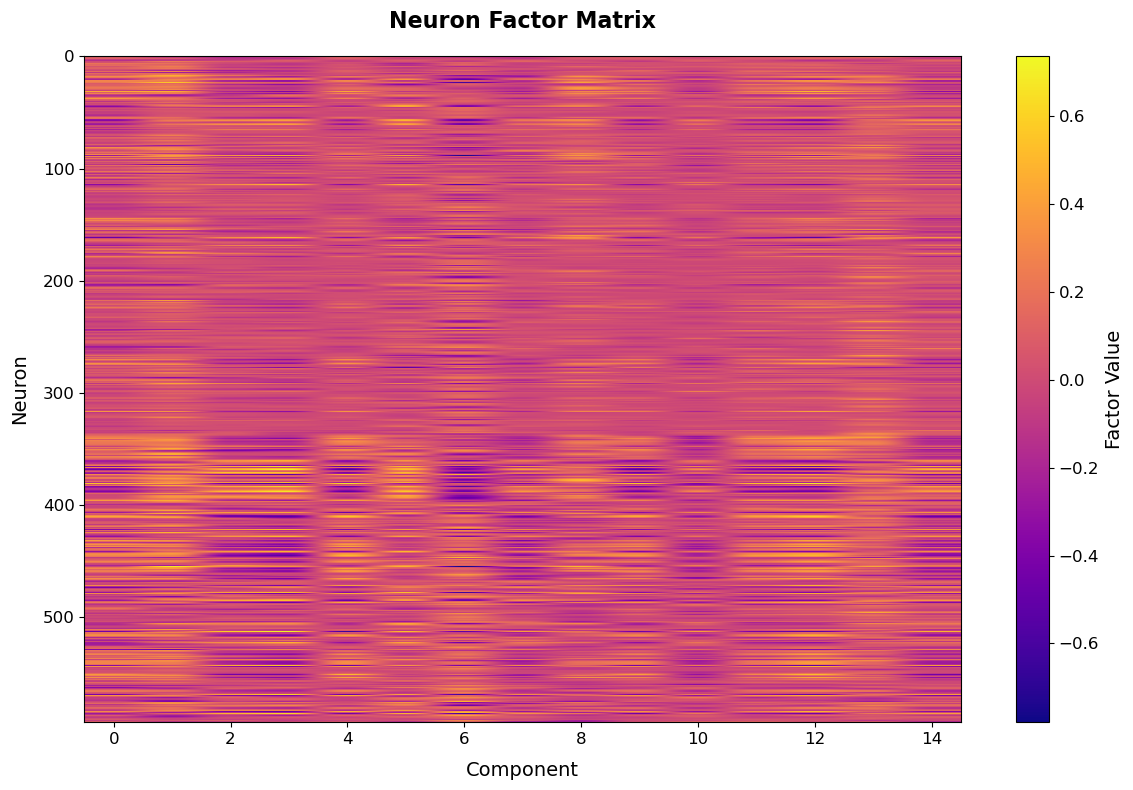

In [205]:
# constuct neurons by factors matrix from the optimal factorization
neurons_by_factors = np.zeros((N_NEURONS, optimal_rank))
neurons_by_factors = optimal_factorization.factors[0]
print(type(optimal_factorization.factors[0]))
print(optimal_factorization.factors[0].shape)

plt.figure(figsize=(12, 8))  
plt.imshow(neurons_by_factors, aspect='auto', cmap='plasma')

plt.title('Neuron Factor Matrix', fontsize=16, weight='bold', pad=20)
plt.xlabel('Component', fontsize=14, labelpad=10)
plt.ylabel('Neuron', fontsize=14, labelpad=10)

cbar = plt.colorbar(label='Factor Value')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label('Factor Value', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  
plt.show()


In [206]:
from ian.ian import * 
from ian.embed_utils import *
from ian.dset_utils import *
from ian.utils import *

In [207]:
def remove_duplicates(data):
    """Removes duplicate rows from a numpy array"""
    return np.unique(data, axis=0)
### why duplicates? neurons with same facors in all components?

neurons_by_factors_unique = remove_duplicates(neurons_by_factors)
print(neurons_by_factors.shape)
print(neurons_by_factors_unique.shape)

(594, 15)
(594, 15)


<class 'numpy.ndarray'>
(594, 594)
### Iteration 1 done. (1.02 s) - pruned 1 edge(s)
### Iteration 2 done. (0.30 s) - pruned 1 edge(s)
### Iteration 3 done. (0.19 s) - pruned 1 edge(s)
### Iteration 4 done. (0.17 s) - pruned 1 edge(s)
### Iteration 5 done. (0.22 s) - pruned 1 edge(s)
### Iteration 6 done. (0.23 s) - pruned 1 edge(s)
### Iteration 7 done. (0.26 s) - pruned 1 edge(s)
### Iteration 8 done. (0.23 s) - pruned 1 edge(s)
CONVERGED: no change in unweighted graph.
Total # edges pruned: 8, (0 disconnected points)
C-tuning weighted graph...
Unweighted graph stats: mean=1.331, median=1.035
Weighted graph stats: mean=1.415, median=1.080


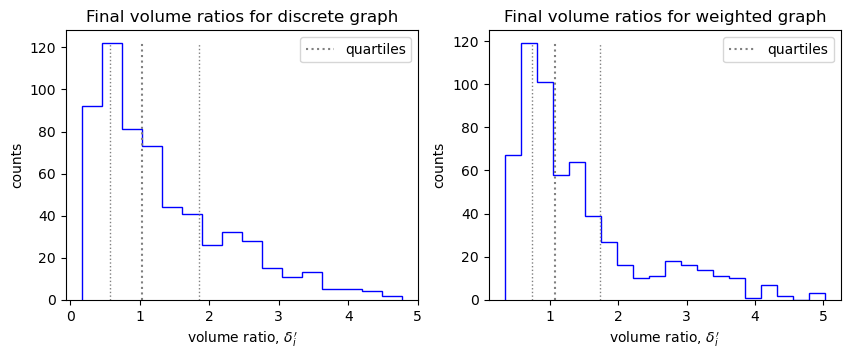

In [208]:
D2 = pwdists(neurons_by_factors_unique, sqdists=True)
print(type(D2))
print(D2.shape)

G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2)

<class 'numpy.ndarray'>
(594, 3)


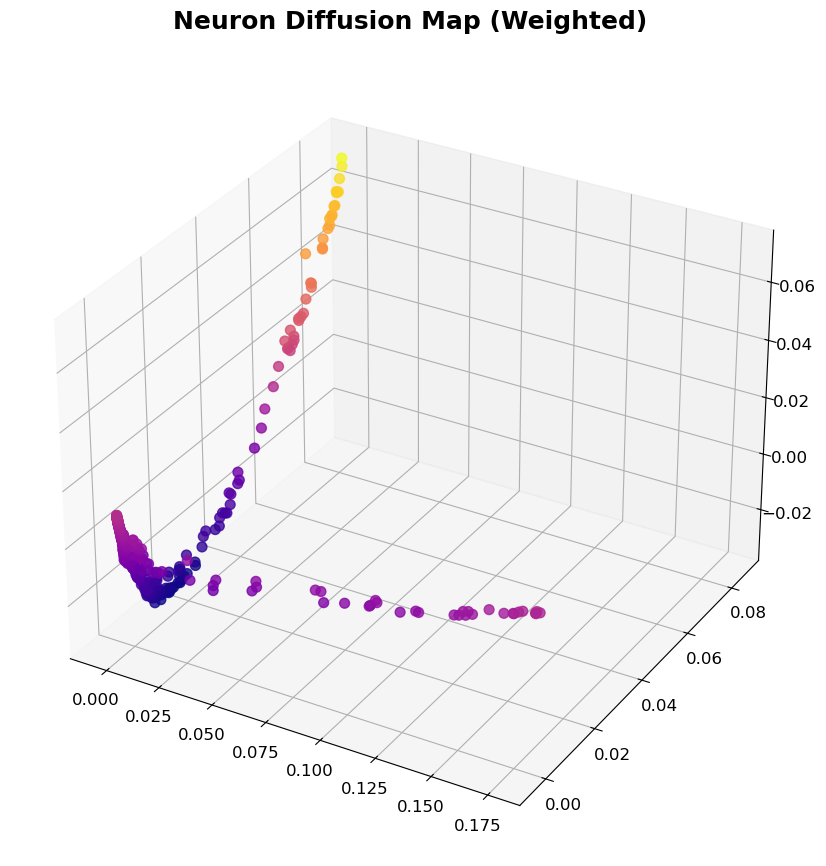

In [209]:
diffusion = SpectralEmbedding(n_components=3, affinity='precomputed')
embedding = diffusion.fit_transform(wG)
print(type(embedding))
print(embedding.shape)

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 10))  # Adjusted figure size
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Z-axis values
sc = ax.scatter(
    embedding[:, 0], embedding[:, 1], embedding[:, 2],
    c=embedding[:, 2], cmap='plasma', s=50, alpha=0.8  # Color based on Z values
)

# Set title with adjusted font size and weight
ax.set_title('Neuron Diffusion Map (Weighted)', fontsize=18, fontweight='bold', pad=20)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Fix layout to ensure labels are visible
plt.subplots_adjust(left=0.1, right=22.9, top=0.9, bottom=0.1)

# Show the plot
plt.show()

<class 'numpy.ndarray'>
(594, 3)


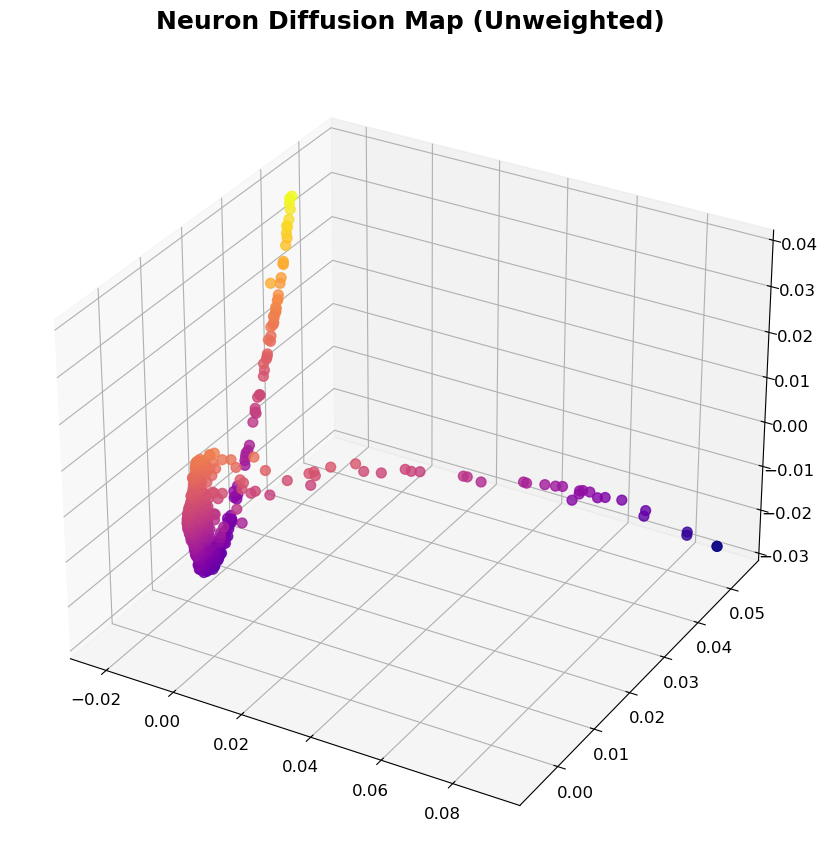

In [210]:
diffusion = SpectralEmbedding(n_components=3, affinity='precomputed')
embedding = diffusion.fit_transform(G)
print(type(embedding))
print(embedding.shape)

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 10))  # Adjusted figure size
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Z-axis values
sc = ax.scatter(
    embedding[:, 0], embedding[:, 1], embedding[:, 2],
    c=embedding[:, 2], cmap='plasma', s=50, alpha=0.8  # Color based on Z values
)

# Set title with adjusted font size and weight
ax.set_title('Neuron Diffusion Map (Unweighted)', fontsize=18, fontweight='bold', pad=20)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Fix layout to ensure labels are visible
plt.subplots_adjust(left=0.1, right=22.9, top=0.9, bottom=0.1)

# Show the plot
plt.show()

# End